# Behavioural validation of the extreme PCA

Run the MVET_IDP_PCA.ipynb first to find the extreme principal components (PCs).
In this script we are going to look at the correlation between the first two extreme PCs and several behavioural measures from the UKB.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn import linear_model, metrics
#sns.set(style='whitegrid')
sns.set(style='ticks', palette='Set2')
sns.despine()

<Figure size 432x288 with 0 Axes>

In [2]:
from matplotlib import rcParams
rcParams['font.family'] = "sans-serif"
rcParams['font.sans-serif'] = "Arial"
colors = ['#2e3037', '#90e6e2', '#666666', '#f35b6a', '#fbb2b9', '#999fa9', '#39c0ba', '#e2e7ee']

In [3]:
def retrieve_UKBB_covariates(csv_file_path, fields_code_list, fileds_name_list, 
                             save_path = None, drop_nans = True):
    '''
    Example:
        csv_file_path = '/project_freenas/3022017.02/UKB/phenotypes/ukb35187.csv'
        save_path =  '/project_freenas/3022017.02/UKB/phenotypes/test.csv'
        fields_code_list = ['21003-2.0', '31-0.0', '54-2.0']
        fileds_name_list = ['age', 'gender', 'site_id']
        
        covariates, subs = retrieve_UKBB_covariates(csv_file_path, fields_code_list, 
                                          fileds_name_list, save_path)
    '''
    
    ukbb_covariates = pd.read_csv(csv_file_path, encoding= 'unicode_escape', 
                                   usecols=['eid'] + fields_code_list)
    if drop_nans:
        ukbb_covariates = ukbb_covariates.dropna()
    ukbb_subs = list(ukbb_covariates['eid'])
    ukbb_subs = [str(u) for u in ukbb_subs]
    ukbb_covariates['eid'] = ukbb_subs
    ukbb_covariates = ukbb_covariates.set_index('eid')
    c = dict()
    for i, code in enumerate(fields_code_list):
        c[code] = fileds_name_list[i]
    ukbb_covariates = ukbb_covariates.rename(columns=c)
    if save_path is not None:
        ukbb_covariates.to_csv(save_path)
    return ukbb_covariates, ukbb_subs

# Fluid intelligence
First we will look with a bit more detail at fluid intelligence, as this is usually used to validate a new method.

In [4]:
# Remove num memory, for very few participants and pros mem, as categorical
# https://biobank.ctsu.ox.ac.uk/crystal/label.cgi?id=100026
cp_code_list = [#'4282-2.0', # Numeric memory
                '20016-2.0', # Reasoning/fluid int
                #'20023-2.0', # Reaction time
                #'399-2.2', # Visual memory, pair matching
                #'21004-2.0', # tower_rearranging, number puzzles correct
                #'6348-2.0', # duration trail n
                #'6350-2.0', # duration trail a
                #'6373-2.0', # matrix pattern puzzles solved
                #'23324-2.0' # digits matched correctly
               ] #  399 had 3 pair and 6 pair
cp_name_list = [#'Numeric_memory',
                'Fluid_intelligence', 
                #'Reaction_time', 
                #'Visual_memory', 
                #'tower_rearranging', 
                #'trail_making_n', 
                #'trail_making_a',
                #'matrix_pattern_completion', 
                #'symbol_digit_substitution'
               ] #'numeric_memory'
#CPs, subs = retrieve_UKBB_covariates('/project_freenas/3022017.02/UKB/phenotypes/current/32_cognitive_phenotypes.csv', cp_code_list, cp_name_list)
CPs, subs = retrieve_UKBB_covariates('/project_cephfs/3022017.06/UKB/phenotypes/current/32_cognitive_phenotypes.csv', cp_code_list, cp_name_list)

## Preprocess the behavioural data
1. To make the data more Gaussian transfer some to log space
2. Normalize before PCA, as PCA tries to maximize the variance, and otherwise the largest component will explain the most variance. 

In [5]:
#CPs['Reaction_time'] = np.log(CPs['Reaction_time'])
#CPs['Visual_memory'] = np.log(CPs['Visual_memory']+1)
scaler = MinMaxScaler()
CPs_scaled = scaler.fit_transform(CPs)
CPs_scaled_df = pd.DataFrame(data = CPs_scaled, columns = CPs.columns)
CPs_scaled_df.describe()
CPs_scaled_df.index = list(map(int,subs))

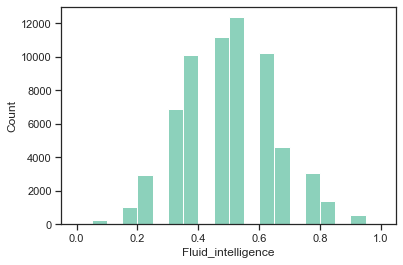

In [6]:
for cp in cp_name_list:
    plt.figure()
    sns.histplot(data=CPs_scaled_df[cp], bins = 20)

## Select standard PC or extreme PC
Select the participants that have both the PCs (brain data) and the CPs data available. 
Select if you want the standard space PCs (PCs_ss.csv) or the extreme PCs (PCs.csv)

In [7]:
Z_df = pd.read_csv('/project_cephfs/3022017.06/projects/big_data/data/ukb_processed_4/deviation_scores.csv', index_col=0)

In [8]:
standard = False #else extreme
if standard:
    PCs_df = pd.read_csv('/home/preclineu/chafra/Desktop/code_phd/data/data/PCs_ss.csv')
    ending = 'standard'
else:
    PCs_df = pd.read_csv('/home/preclineu/chafra/Desktop/code_phd/data/data/PCs.csv')
    ending = 'extreme'

PCs_df.index = Z_df.index

In [9]:
CPs_scaled_df_dep = CPs_scaled_df.loc[CPs_scaled_df.index.intersection(PCs_df.index)]
PCs_df_dep = pd.DataFrame(PCs_df.loc[CPs_scaled_df.index.intersection(PCs_df.index)])
CPs_PCs_df = pd.concat([CPs_scaled_df_dep, PCs_df_dep], axis=1)
#sns.pairplot(data = CPs_PCs_df.iloc[:,0:10], corner=True)

## Correlation PC and fluid intelligence 

In [10]:
rho = np.zeros(np.shape(PCs_df_dep)[1])
p = np.zeros(np.shape(PCs_df_dep)[1])
for i in range(np.shape(PCs_df_dep)[1]):
    rho[i], p[i] = stats.spearmanr(CPs_scaled_df_dep, PCs_df_dep.iloc[:,i])
    #print('stat:', rho[i], 'pval:', p[i])

In [11]:
p_df = pd.DataFrame(p, columns=['pvalue'])
p_df = p_df.reset_index()

# Correlation non-IDPs

Correlate the first two extreme PCs to different non IDP values, using a standard spearmanr correlation. The spearmanr correlation does not assume that both distributions are normally distributed. 

Code based on this amazing paper: 
- Non-linearity matters: a deep learning solution to generalization of hidden brain patterns across population cohorts Mariam Zabihi.

In [12]:
PCs=PCs_df.iloc[:,0:3]
nIDP_df=pd.read_csv('/project_cephfs/3022017.06/projects/big_data/data/nIDPs.csv',index_col=0)
data_dictionary=pd.read_csv('/home/preclineu/chafra/Desktop/code_phd/EVT/data_dictionary.csv',index_col=0)
nIDP_df = nIDP_df.set_index('Subject')

In [13]:
X = PCs.join(nIDP_df)
P = pd.DataFrame()
for nIDP in nIDP_df: 
    df=X[['V1','V2', 'V3' ,nIDP]]
    df = df.dropna()
    r,p=spearmanr(df[['V1','V2', 'V3']],df[nIDP])
    pvalue=pd.DataFrame(columns=['FieldID-instance'],data=[nIDP])
    pvalue[['PC1','PC2', 'PC3']]=[-np.log10(p[3,:3])]
    P=pd.concat([P,pvalue])
    
Pvalue=pd.merge(data_dictionary[['FieldID-instance','nIDP_category','Field']],P,how='inner',on='FieldID-instance')
Pvalue=Pvalue.reset_index()
Pvalue=Pvalue.rename(columns={'index':'nIDPs'})
Pvalue=Pvalue.drop(Pvalue[Pvalue['nIDP_category']=='age_sex_site'].index)
Pvalue.head()

,nIDPs,FieldID-instance,nIDP_category,Field,PC1,PC2,PC3
0,0,398-2.3,cognitive_phenotypes,Number of correct matches in round,1.796952,3.281780,1.922340
1,1,399-2.1,cognitive_phenotypes,Number of incorrect matches in round,6.019004,12.820235,1.393820
2,2,399-2.2,cognitive_phenotypes,Number of incorrect matches in round,0.604042,6.327577,1.357693
3,3,399-2.3,cognitive_phenotypes,Number of incorrect matches in round,1.332634,1.019978,0.830405
4,4,400-2.1,cognitive_phenotypes,Time to complete round,3.369264,19.542107,2.796396


Manhattan plot of the p-values for the univariate correlation of non-imaging measures with the first two extreme PCAs and the standard PCAs. The black line shows the Bonferonni-corrected p-value threshold.
We use the log10 scale, so we have to look at values that pass the black line.

In [14]:
print(f'PCA1, Number of correlations passing p-value: {np.sum(P.iloc[:,1]>-np.log10(.05/len(P)))}')
print(f'PCA2, Number of correlations passing p-value: {np.sum(P.iloc[:,2]>-np.log10(.05/len(P)))}')
print(f'PCA3, Number of correlations passing p-value: {np.sum(P.iloc[:,3]>-np.log10(.05/len(P)))}')

PCA1, Number of correlations passing p-value: 51
PCA2, Number of correlations passing p-value: 135
PCA3, Number of correlations passing p-value: 37


## Correlation diagnosis and extreme PCAs
The IDP codes can be found here:
https://biobank.ndph.ox.ac.uk/showcase/coding.cgi?id=6
We will look at two diagnosis that we expect to have extreme values:
chronic/degenerative neurological problem:
- motor neurone disease (69) - 1259
- myasthenia gravis (59) - 1260
- multiple sclerosis (1995) - 1261
- parkinsons disease (1011) - 1262
- dementia/alzheimers/cognitive impairment (154) - 1263
- other demyelinating disease (not multiple sclerosis) (81) - 1397

In [15]:
#df = pd.read_csv("/project_cephfs/3022017.06/UKB/phenotypes/current/50_health_outcomes_headers.csv")
#diagnosis_ids = [col for col in df if col.startswith('20002')]
#diagnosis_ids.append('eid')
#diagnosis_df = pd.read_csv("/project_cephfs/3022017.06/UKB/phenotypes/current/50_health_outcomes.csv") #, usecols = diagnosis_ids)
#diagnosis_df = diagnosis_df.set_index('eid')

In [16]:
degenerative_df = pd.read_csv("/project_cephfs/3022017.06/UKB/phenotypes/current/50_health_outcomes.csv", usecols=['eid','20002-0.1259', '20002-0.1260', '20002-0.1261', '20002-0.1262', '20002-0.1263', '20002-0.1397'])
print(f'Number of subject with a neurological problem: \n{degenerative_df.sum()}')
degenerative_df = degenerative_df.set_index('eid')

Number of subject with a neurological problem: 
eid             1764664199487
20002-0.1259               68
20002-0.1260               58
20002-0.1261             1850
20002-0.1262              997
20002-0.1263              164
20002-0.1397               80
dtype: int64


We want to correlate a continious variable with a binary variable, so we have to use the Point-Biserial Correlation

In [19]:
# Select only participants that also have brain data
degenerative_df = degenerative_df.loc[degenerative_df.index.intersection(PCs_df.index)]
PCs_df_dep = PCs_df.loc[degenerative_df.index]
print(f'Number of subject with a neurological problems and brain data: {degenerative_df.sum().sum()}')

Number of subject with a neurological problems and brain data: 240


In [20]:
PCs=PCs_df.iloc[:,0:3]
X = PCs.join(degenerative_df)
P = pd.DataFrame()
for nIDP in degenerative_df: 
    df=X[['V1','V2', 'V3',nIDP]]
    df = df.dropna()
    r1, p1 = stats.pointbiserialr(df['V1'],df[nIDP])
    r2, p2 = stats.pointbiserialr(df['V2'],df[nIDP])
    r3, p3 = stats.pointbiserialr(df['V3'],df[nIDP])
    pvalue=pd.DataFrame(columns=['FieldID-instance'],data=[nIDP])
    pvalue['PC1'] = -np.log10(p1)
    pvalue['PC2'] = -np.log10(p2)
    pvalue['PC3'] = -np.log10(p3)
    P=pd.concat([P,pvalue])    

In [21]:
P['nIDP_category'] = 'neurodegenerative_disorders'
P['Field'] = ['motor neurone disease', 'myasthenia gravis', 'multiple sclerosis', 'parkinsons disease', 'dementia/alzheimers/cognitive-impairment', 'other demyelinating disease']

In [22]:
Pvalue_all = pd.concat([P, Pvalue.drop('nIDPs', axis=1)])
Pvalue_all = Pvalue_all.reset_index(drop=True).reset_index()
Pvalue_all=Pvalue_all.rename(columns={'index':'nIDPs'})

In [23]:
Pvalue_all.groupby(['nIDP_category']).size()

nIDP_category
cognitive_phenotypes                   199
lifestyle_environment_alcohol            9
lifestyle_environment_exercise_work     37
lifestyle_environment_general           44
lifestyle_environment_tobacco            4
mental_health                           29
neurodegenerative_disorders              6
dtype: int64

In [24]:
n=0
for item in Pvalue_all.nIDP_category.unique():
    labels =['neurodegenerative disorders', 'cognitive phenotypes',
                                                  'lifestyle environment alcohol',
                                                  'lifestyle environment tobacco', 'lifestyle environment general', 'lifestyle environment exercise work', 'mental health']
    Pvalue_all.nIDP_category = Pvalue_all.nIDP_category.replace(item, labels[n])
    n = n+1

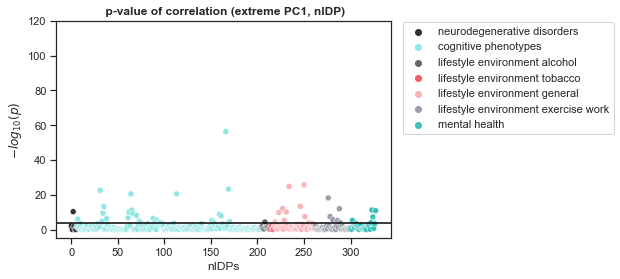

In [25]:
plt.figure()
fig=sns.scatterplot(data=Pvalue_all, x='nIDPs',y='PC1', hue='nIDP_category', palette=colors[0:7])
fig.axhline(-np.log10(.05/len(Pvalue_all)),color='k')
plt.legend(bbox_to_anchor=(1.02,1.02))
plt.title(f' p-value of correlation ({ending} PC1, nIDP)', fontweight="bold")
plt.ylim([-5,120])
plt.ylabel('$-log_{10}(p)$')
plt.savefig('/home/preclineu/chafra/Desktop/figures/'+'fig_14'+ending+'.png',dpi=300, bbox_inches='tight')
plt.show()
plt.close()

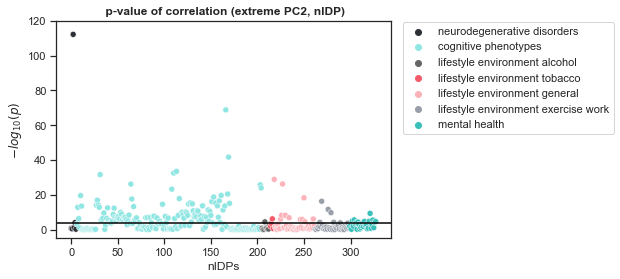

In [26]:
plt.figure()
fig=sns.scatterplot(data=Pvalue_all, x='nIDPs',y='PC2', hue='nIDP_category', palette=colors[0:7])
fig.axhline(-np.log10(.05/len(Pvalue_all)),color='k')

plt.legend(bbox_to_anchor=(1.02,1.02))
plt.title(f' p-value of correlation ({ending} PC2, nIDP)', fontweight="bold")
#plt.savefig(nm_dir+idp+ending+'.png',dpi=300,bbox_inches='tight')
plt.ylim([-5,120])
plt.ylabel('$-log_{10}(p)$')
plt.savefig('/home/preclineu/chafra/Desktop/figures/'+'fig_15'+ ending+ '.png',dpi=300, bbox_inches='tight')
plt.show()
plt.close()

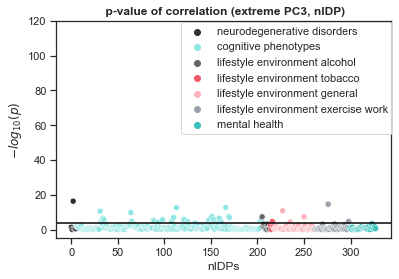

In [27]:
plt.figure()
fig=sns.scatterplot(data=Pvalue_all, x='nIDPs',y='PC3', hue='nIDP_category', palette=colors[0:7])
fig.axhline(-np.log10(.05/len(Pvalue_all)),color='k')
plt.legend(bbox_to_anchor=(1.02,1.02))
plt.title(f' p-value of correlation ({ending} PC3, nIDP)', fontweight="bold")
#plt.savefig(nm_dir+idp+ending+'.png',dpi=300,bbox_inches='tight')
plt.ylim([-5,120])
plt.ylabel('$-log_{10}(p)$')
plt.show()
plt.close()

In [28]:
print(f'PC1, Number of correlations passing p-value: {np.sum(Pvalue_all.iloc[:,2]>-np.log10(.05/len(Pvalue_all)))}')
print(f'PC2, Number of correlations passing p-value: {np.sum(Pvalue_all.iloc[:,3]>-np.log10(.05/len(Pvalue_all)))}')
print(f'PC3, Number of correlations passing p-value: {np.sum(Pvalue_all.iloc[:,4]>-np.log10(.05/len(Pvalue_all)))}')

PC1, Number of correlations passing p-value: 51
PC2, Number of correlations passing p-value: 137
PC3, Number of correlations passing p-value: 36
